In [23]:
import numpy as np
import xtrack as xt
import xobjects as xo
import xpart as xp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import constants 


line = xt.Line.from_json('sps.json')
particle_ref=line.particle_ref

line.build_tracker()
#line.freeze_longitudinal()
# line.optimize_for_tracking()

twiss=line.twiss()

clight=constants.speed_of_light
circumference = line.get_length()

#%%
###################
# Linear Transfer #
###################

qx=twiss['qx']
qy=twiss['qy']
dqx=twiss['dqx']
dqy=twiss['dqy']
circumference=twiss['s'][-1]
# beta_x=twiss['betx'][-1]
# beta_y=twiss['bety'][-1]

qs=twiss['qs']
bets=twiss['betz0']


#at interaction points: #from https://anaconda.org/petrenko/li_like_ca_in_sps/notebook
beta_x  =  54.614389 # m
beta_y  =  44.332517 # m
alpha_x = -1.535235
alpha_y =  1.314101



Dx  =  2.444732 # m
Dpx =  0.097522


Dy  =  0.0 # m
Dpy =  0.0

#index of gamma factory along SPS line: 16675

arc = xt.LineSegmentMap(
        qx=qx, qy=qy,
        dqx=0, dqy=0,
        length=circumference,
        alfx=alpha_x,
        alfy=alpha_y,
        betx=beta_x,
        bety=beta_y,
        
        dx=Dx,
        dpx=Dpx,
        dy=Dy,
        dpy=Dpy,
        qs=qs,
        bets=bets,
        )


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [24]:
from ion_properties import ions,lead,calcium,xenon

ion=calcium

In [25]:
for ion in [lead]:# Ion properties:


        # Ion properties:
        q0 = ion.q0
        mass0 = ion.mass0

        gamma = ion.gamma_rel
        beta=  np.sqrt(1-1/(gamma*gamma))
        p0c = mass0*gamma*beta #eV/c

        bunch_intensity = ion.Intensity

        particle_ref = xp.Particles(p0c=p0c, mass0=mass0, q0=q0,gamma0=gamma)

        line.particle_ref=particle_ref


        nemitt = 1.5e-6 # m*rad (normalized emittance)
        sigma_z = 0.063 # m

        emittance=nemitt/(beta*gamma)

        num_particles=int(5e3)

        line_arc=xt.Line(
                elements=[arc])
        line_arc.build_tracker()

        particles = xp.generate_matched_gaussian_bunch(
                num_particles=num_particles,
                total_intensity_particles=bunch_intensity,
                nemitt_x=nemitt, nemitt_y=nemitt, sigma_z=sigma_z,
                particle_ref=particle_ref,
                line=line_arc,        
                )

        particles0=particles.copy()
        # sigma_dp=2e-4  
        sigma_dp=np.std(particles.delta)
        print(sigma_dp)
        sigma_dp=2e-4  
        ##################
        # Laser Cooler #
        ##################

        #laser-ion beam collision angle
        theta_l = 2.6*np.pi/180 # rad
        nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

        # Ion excitation energy:
        ion_excited_lifetime=ion.excited_lifetime
        hw0 = ion.hw0 # eV
        hc=constants.hbar*clight/constants.e # eV*m (ħc)
        lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

        lambda_l = ion.lambda_l

        # # Shift laser wavelength for fast longitudinal cooling:5
        # lambda_l = lambda_l*(1+1*sigma_dp) # m

        laser_frequency = clight/lambda_l # Hz
        sigma_w = 2*np.pi*laser_frequency*sigma_dp
        #sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

        sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
        print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
        print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

        laser_waist_radius = 1.3e-3 #m
        laser_energy = 5e-3

        laser_x=-1*1e-3

        #sigma_t=sigma_t*0.70 # to get 1.9 ps
        # sigma_t=1.9e-12

        GF_IP = xt.PulsedLaser(
                        laser_x=-1.7346938775510203*1e-3,
                        laser_y=0,
                        laser_z=0,
                        
                        laser_direction_nx = 0,
                        laser_direction_ny = ny,
                        laser_direction_nz = nz,
                        laser_energy         = laser_energy, # J
                        laser_duration_sigma = sigma_t, # sec
                        laser_wavelength = lambda_l, # m
                        laser_waist_radius = laser_waist_radius, # m
                        laser_waist_shift = 0, # m
                        ion_excitation_energy = hw0, # eV
                        ion_excited_lifetime  = ion_excited_lifetime, # sec                   
                        )

        # simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
        max_time_s = 0.6
        int_time_s = 0.01
        T_per_turn = circumference/(clight*beta)
        num_turns = int(max_time_s/T_per_turn)
        save_interval = int(int_time_s/T_per_turn)

        # num_turns = int(1e3)
        # save_interval = num_turns/100
        # # save_interval=1

        # create a monitor object, to reduce holded data
        monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                                n_repetitions=int(num_turns/save_interval),
                                repetition_period=save_interval,
                                num_particles=num_particles)


        # line.discard_tracker()
        # IP_index=16675   
        # line.insert_element('monitor', element=monitor, index=IP_index)
        # line.insert_element('GF_IP', element=GF_IP, index=IP_index) #this way monitor comes after the laser
        # SPS_line.append_element(monitor,'monitor')
        # SPS_line.append_element(GF_IP,'GF_IP')
        lambda_l_list=np.linspace(lambda_l*(1-2e-4),lambda_l*(1+2e-4),25)
        final_emittance_list = []
        final_dp_p=[]
        # cooler_growth_rates_list=[]
        # cooler_heating_growth_rates_list=[]
        transverse_growth_rate_list=[]
        longitudinal_growth_rate_list=[]

        from scipy.optimize import curve_fit

        plt.figure(figsize=(12, 8))
        plt.rcParams.update({'font.size': 25})

        for laser_wavelength_loop in tqdm(lambda_l_list):
        
                GF_IP.laser_wavelength=laser_wavelength_loop
                particles=particles0.copy()

                line = xt.Line(
                        elements=[monitor,GF_IP,arc])

                context = xo.ContextCpu(omp_num_threads=1)
                line.build_tracker(_context=context)
                # line.optimize_for_tracking()

                line.track(particles, num_turns=num_turns,
                        turn_by_turn_monitor=False,with_progress=True)

                # extract relevant values
                x = monitor.x[:,:,0]
                px = monitor.px[:,:,0]
                y = monitor.y[:,:,0]
                py = monitor.py[:,:,0]
                delta = monitor.delta[:,:,0]
                zeta = monitor.zeta[:,:,0]
                state = monitor.state[:,:,0]
                time = monitor.at_turn[:, 0, 0] * T_per_turn

                gamma_x=(1+alpha_x**2)/beta_x
                gamma_y=(1+alpha_y**2)/beta_y

                action_x = (gamma_x*(x-Dx*delta)**2 + 2*alpha_x*(x-Dx*delta)*(px-Dpx*delta)+ beta_x*(px-Dpx*delta)**2)
                action_y = (gamma_y*(y-Dy*delta)**2 + 2*alpha_y*(y-Dy*delta)*(py-Dpy*delta)+ beta_y*(py-Dpy*delta)**2)

                emittance_x=np.mean(action_x,axis=1)*gamma/2

                # Define the exponential function
                def exponential_func(x, a, b):
                        return a * np.exp(x * b)
                
                # Fit the data to the exponential function
                params_transverse, covariance = curve_fit(exponential_func, time, emittance_x)

                # Extract the parameters
                a, b = params_transverse

                transverse_growth_rate_list.append(b)

                final_emittance_list.append(emittance_x[-1])

                # plt.plot(time,emittance_x*1e6, linewidth=5.0)
                # plt.plot(time, exponential_func(time,
                # *params_transverse) * 1e6, linestyle='--')
                
                # Fit the data to the exponential function
                rms_dp_p = np.std(delta, axis=1)
                window_size = 10  # or any other suitable value
                rms_dp_p_smoothed = np.convolve(rms_dp_p, np.ones(window_size)/window_size, mode='valid')


                params_longitudinal, covariance = curve_fit(exponential_func, time[:len(rms_dp_p_smoothed)], rms_dp_p_smoothed)

                # Extract the parameters
                a, b = params_longitudinal

                longitudinal_growth_rate_list.append(b)

                final_dp_p.append(rms_dp_p[-1])


        np.savez(f'results/optimal_wavelength/{ion.name}.npz', transverse_growth_rate_list=transverse_growth_rate_list,
                longitudinal_growth_rate_list=longitudinal_growth_rate_list,final_dp_p=final_dp_p,
                final_emittance_list=final_emittance_list,lambda_l_list=lambda_l_list,nemitt=nemitt,time=time)


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00020088115819437018
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm


  0%|          | 0/25 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:30<12:23, 30.98s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

  8%|▊         | 2/25 [01:01<11:48, 30.80s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 12%|█▏        | 3/25 [01:31<11:11, 30.52s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 16%|█▌        | 4/25 [02:02<10:40, 30.50s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 20%|██        | 5/25 [02:32<10:08, 30.40s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 24%|██▍       | 6/25 [03:02<09:35, 30.30s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 28%|██▊       | 7/25 [03:32<09:04, 30.27s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 32%|███▏      | 8/25 [04:03<08:35, 30.30s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 36%|███▌      | 9/25 [04:33<08:03, 30.21s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 40%|████      | 10/25 [05:03<07:32, 30.16s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 44%|████▍     | 11/25 [05:33<07:02, 30.17s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 48%|████▊     | 12/25 [06:05<06:37, 30.59s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 52%|█████▏    | 13/25 [06:35<06:05, 30.46s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 56%|█████▌    | 14/25 [07:05<05:33, 30.32s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 60%|██████    | 15/25 [07:35<05:03, 30.34s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 64%|██████▍   | 16/25 [08:05<04:32, 30.25s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 68%|██████▊   | 17/25 [08:35<04:01, 30.20s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 72%|███████▏  | 18/25 [09:05<03:29, 29.97s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 76%|███████▌  | 19/25 [09:34<02:58, 29.75s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 80%|████████  | 20/25 [10:04<02:28, 29.74s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 84%|████████▍ | 21/25 [10:33<01:59, 29.75s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 88%|████████▊ | 22/25 [11:03<01:29, 29.81s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 92%|█████████▏| 23/25 [11:33<00:59, 29.69s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 96%|█████████▌| 24/25 [12:02<00:29, 29.70s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

100%|██████████| 25/25 [12:32<00:00, 30.11s/it]


<Figure size 1200x800 with 0 Axes>

Transverse emittance

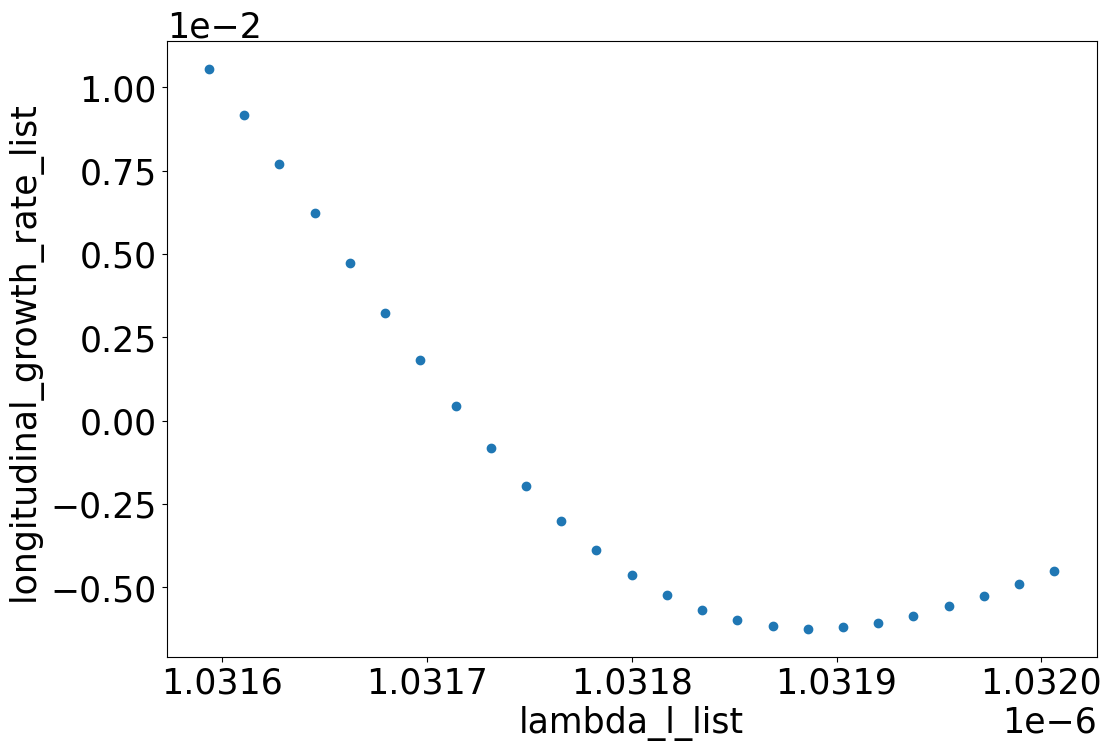

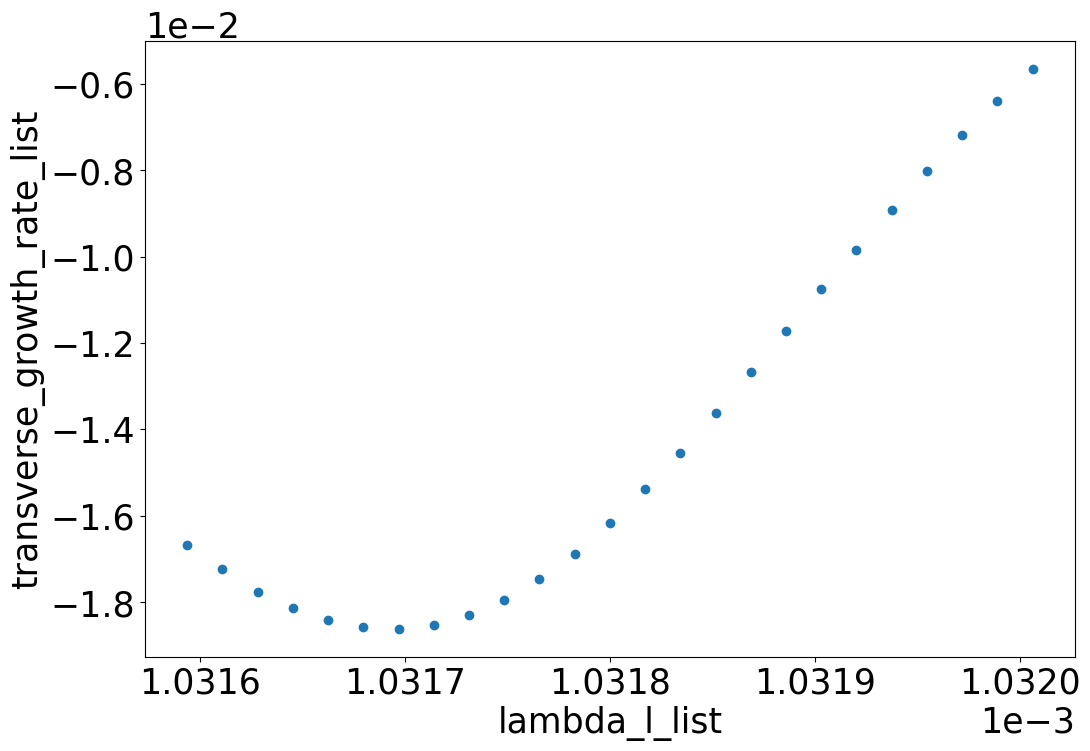

In [26]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.scatter(lambda_l_list,longitudinal_growth_rate_list)
plt.xlabel('lambda_l_list')
plt.ylabel('longitudinal_growth_rate_list ')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.xaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.scatter(lambda_l_list*1e3,transverse_growth_rate_list)
plt.xlabel('lambda_l_list')
plt.ylabel('transverse_growth_rate_list')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.xaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.savefig('Optimal_laser_offset.png',dpi=300)
plt.show()